# EXPLORATORY DATA ANALYSIS of FINANCIAL DATA

## Introduction

Financial time series have unique characteristics that differentiate them from other types of data. This notebook performs an exploratory data analysis on stock price data to highlight statistical properties commonly observed in financial markets.

We'll explore:
- Basic statistical properties of returns
- Tests for normality and stationarity
- Autocorrelation patterns in returns and volatility
- Volatility clustering and persistence
- Leverage effect across different timeframes

## Data Loading

We'll use the `Stock` class and `loader.py` to retrieve historical daily price data from Yahoo Finance. The class handles downloading, cleaning, and calculating log returns automatically.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stock import Stock

We can choose any valid ticker symbol for our analysis. The class will download the data from Yahoo Finance using the `yfinance` library.

In [2]:
ticker = 'AAPL'
my_stock = Stock(ticker)
try:
    my_stock.load_data()
    if len(my_stock.df) < 250: # 1 year of trading days
        raise ValueError(f"Insufficient data: only {len(my_stock.df)} observations")
except Exception as e:
    print(f"Error loading data for {ticker}: {e}")
    raise

From AAPL dataset were removed 3 rows with missing or incorrect data
Ticker: AAPL has 1 anomalies:
  Open-pClose Anomalies: 1


## Stock Overview

Let's first examine the basic information about our stock data:

In [3]:
print(my_stock.ticker)
print(f"Period: {my_stock.first_date.strftime('%Y-%m-%d')} to {my_stock.last_date.strftime('%Y-%m-%d')}")
print("\nSample of price data:")
print(my_stock.df.head())
print("\nLatest price data:")
print(my_stock.df.tail())

AAPL
Period: 1995-01-03 to 2025-10-31

Sample of price data:
                             Open    High     Low   Close      Volume  \
Date                                                                    
1995-01-03 00:00:00-05:00  0.2885  0.2885  0.2810  0.2848   103868800   
1995-01-04 00:00:00-05:00  0.2866  0.2940  0.2866  0.2922   158681600   
1995-01-05 00:00:00-05:00  0.2912  0.2922  0.2875  0.2885    73640000   
1995-01-06 00:00:00-05:00  0.3089  0.3200  0.3052  0.3117  1076622400   
1995-01-09 00:00:00-05:00  0.3089  0.3107  0.3042  0.3057   274086400   

                           Dividends  Stock Splits   Returns  Log_Returns  
Date                                                                       
1995-01-03 00:00:00-05:00        0.0           0.0       NaN          NaN  
1995-01-04 00:00:00-05:00        0.0           0.0  0.025983     0.025651  
1995-01-05 00:00:00-05:00        0.0           0.0 -0.012663    -0.012743  
1995-01-06 00:00:00-05:00        0.0           

In [4]:
# Display key company information
print("Key Information:")
print("-" * 50)
important_keys = ['shortName', 'country', 'sector', 'industry', 'marketCap', 'beta', 'forwardEps', 'trailingEps', 'forwardPE', 'trailingPE']
for key in important_keys:
    if key in my_stock.info:
        print(f"{key}: {my_stock.info[key]}")

Key Information:
--------------------------------------------------
shortName: Apple Inc.
country: United States
sector: Technology
industry: Consumer Electronics
marketCap: 3995082424320
beta: 1.094
forwardEps: 8.31
trailingEps: 7.46
forwardPE: 32.535496
trailingPE: 36.242626


In [5]:
# Plot historical prices
fig = my_stock.plot_close(log_scale=True)
if fig:
    fig.show()

## Statistical Properties of Returns

In [6]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

Financial prices tend to be non-stationary trending time series, so we analyze log returns which are more stationary and better suited for statistical analysis.

In [7]:
stock_returns = my_stock.df['Log_Returns'].dropna()

In [8]:
# Comprehensive statistics
print(f"{my_stock.ticker} Log Returns Analysis, period: {my_stock.first_date.strftime('%Y.%m.%d')} - {my_stock.last_date.strftime('%Y.%m.%d')}")
print("-" * 75)
print(f"Mean:     {stock_returns.mean():.6f}")
print(f"Median:   {stock_returns.median():.6f}")
print(f"Std Dev:  {stock_returns.std():.6f}")
print(f"Skewness: {stock_returns.skew():.6f}")
print(f"Kurtosis: {stock_returns.kurtosis():.6f}")  # Excess kurtosis
print("")
print("A skewness value deviating from zero suggests the distribution is either right-skewed (positive skewness)")
print("or left-skewed (negative skewness).")
print("Excess kurtosis significantly greater than 0 indicates the presence of heavy tails in the distribution.")

AAPL Log Returns Analysis, period: 1995.01.03 - 2025.10.31
---------------------------------------------------------------------------
Mean:     0.000884
Median:   0.000781
Std Dev:  0.026978
Skewness: -2.391656
Kurtosis: 75.791664

A skewness value deviating from zero suggests the distribution is either right-skewed (positive skewness)
or left-skewed (negative skewness).
Excess kurtosis significantly greater than 0 indicates the presence of heavy tails in the distribution.


## Tests for Normality and Stationarity

Financial returns are often approximately stationary in mean, typically non-normal with heavy tails and volatility clustering. Let's test these properties:

In [9]:
alpha = 0.01  # significance level
# Normality test (Jarque-Bera)
stat, p_value = stats.jarque_bera(stock_returns)
print(f"\nJarque-Bera test for normality:")
print(f"p-value: {p_value:.6f}")
print("(p-value close to 0 indicates non-normality)")
print(f"{'Reject normality' if p_value < alpha else 'Do not reject normality'} at α={alpha}")

# Stationarity test (Augmented Dickey-Fuller)
adf_result = adfuller(stock_returns)
print(f"\nADF test for stationarity:")
print(f"p-value: {adf_result[1]:.6f}")
print("(p-value close to 0 indicates stationarity)")
print(f"{'Reject unit root (stationary)' if adf_result[1] < alpha else 'Do not reject unit root'} at α={alpha}")

# Autocorrelation: Ljung–Box on returns (linear autocorrelation) and on squared returns (vol clustering)
# L-B is a cumulative test checking if a group of autocorrelations are jointly non-zero.
lags = [1, 5, 10, 20]
lb_ret = acorr_ljungbox(stock_returns, lags=lags, return_df=True)
lb_sqr = acorr_ljungbox(stock_returns**2, lags=lags, return_df=True)

print("\nLjung–Box p-values for autocorrelation in returns:")
print(", ".join([f"lag {l}: {lb_ret.loc[l, 'lb_pvalue']:.6f}" for l in lags]),
      f" -> {'Some Autocorrelation detected' if (lb_ret['lb_pvalue']<alpha).any() else 'No strong Autocorrelation'} at α={alpha}")

print("Ljung–Box p-values for autocorrelation in squared returns:")
print(", ".join([f"lag {l}: {lb_sqr.loc[l, 'lb_pvalue']:.6f}" for l in lags]),
      f" -> {'Volatility clustering likely' if (lb_sqr['lb_pvalue']<alpha).any() else 'No strong evidence'} at α={alpha}")


Jarque-Bera test for normality:
p-value: 0.000000
(p-value close to 0 indicates non-normality)
Reject normality at α=0.01

ADF test for stationarity:
p-value: 0.000000
(p-value close to 0 indicates stationarity)
Reject unit root (stationary) at α=0.01

Ljung–Box p-values for autocorrelation in returns:
lag 1: 0.020102, lag 5: 0.002431, lag 10: 0.000179, lag 20: 0.000046  -> Some Autocorrelation detected at α=0.01
Ljung–Box p-values for autocorrelation in squared returns:
lag 1: 0.006972, lag 5: 0.000847, lag 10: 0.000450, lag 20: 0.004500  -> Volatility clustering likely at α=0.01


## Analysis of Return Distribution

We visualize the empirical distribution of returns and compare it to a normal distribution to assess the degree of deviation from a Gaussian distribution.

Outliers removed: 4


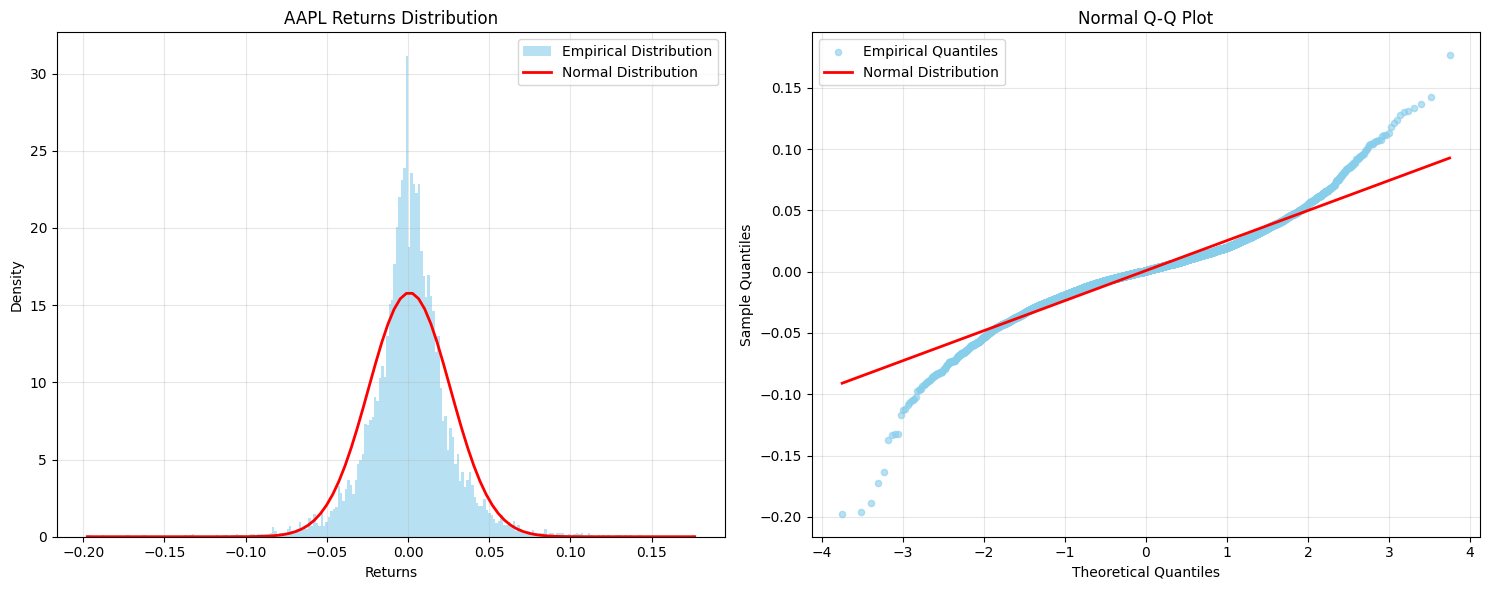

In [10]:
def remove_outliers(data, k:int=2):
    """
    Helper function to remove outliers using IQR (interquartile range) method
    :param data: input data (Pandas Series)
    :param k: multiplier for IQR (default=2 for moderate outlier removal)
    :return: filtered data

    Note: Higher k values remove fewer outliers (e.g., k=8 for light removal)
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # remove some extreme (k*IQR) outliers
    return data[(data >= Q1 - k * IQR) & (data <= Q3 + k * IQR)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Get filtered data for visualization, removing some outliers.
filtered_returns = remove_outliers(stock_returns, k=8)

if len(filtered_returns) < len(stock_returns):
    print(f"Outliers removed: {len(stock_returns) - len(filtered_returns)}")

# Left plot: Returns Distribution
hist, bins, _ = ax1.hist(filtered_returns.dropna(), bins=250, density=True, 
                        alpha=0.6, color='skyblue', label='Empirical Distribution')

# Add normal distribution curve
x_range = np.linspace(filtered_returns.min(), filtered_returns.max(), 100)
normal_dist = stats.norm.pdf(x_range, filtered_returns.mean(), filtered_returns.std())
ax1.plot(x_range, normal_dist, 'r-', lw=2, label='Normal Distribution')

ax1.set_title(f'{my_stock.ticker} Returns Distribution')
ax1.set_xlabel('Returns')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Q-Q Plot
theoretical_quantiles, sample_quantiles = stats.probplot(filtered_returns.dropna(), dist="norm")[0]
slope, intercept = np.polyfit(theoretical_quantiles, sample_quantiles, 1)

ax2.scatter(theoretical_quantiles, sample_quantiles, 
           color='skyblue', alpha=0.6, s=20, label='Empirical Quantiles')

ax2.plot(theoretical_quantiles, slope * theoretical_quantiles + intercept, 
         'r-', lw=2, label='Normal Distribution')

ax2.set_title('Normal Q-Q Plot')
ax2.set_xlabel('Theoretical Quantiles')
ax2.set_ylabel('Sample Quantiles')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Time Series Properties: Autocorrelation Analysis

Returns often exhibit limited serial correlation, while squared returns (a proxy for volatility) typically show significant autocorrelation - a phenomenon known as volatility clustering.

We examine both the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF):
- **ACF** measures total correlation at each lag, including indirect effects
- **PACF** measures direct correlation at each lag, removing intermediate lag effects

**Note on sample size**: With our large dataset (n=7,500+), statistical significance bands become very narrow (±0.023), making even economically trivial correlations statistically significant. 
Therefore, we introduce also **economic significance** using absolute thresholds (e.g., |correlation| > 0.05) rather than relying solely on statistical significance.


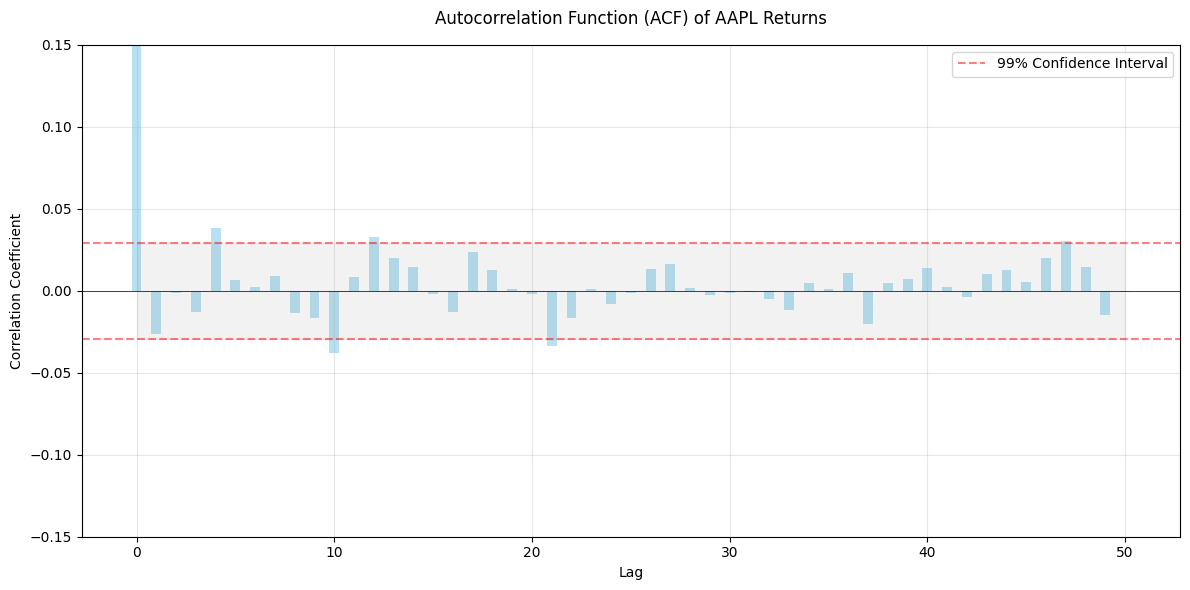


No significant autocorrelation found at any lag.
Interpretation: Returns appear to follow a random walk, consistent with market efficiency.


In [11]:
# ACF Chart

plt.figure(figsize=(12, 6))

# Calculate ACF values (including lag 0)
acf_values = acf(stock_returns, nlags=50, fft=True)
lags = np.arange(0, len(acf_values))

# Calculate confidence intervals (either 95% or 99%)
n = len(stock_returns)
#conf_level = 1.96 / np.sqrt(n)      # 95% confidence interval
conf_level = 2.576 / np.sqrt(n)      # 99% confidence interval

# Create the plot
plt.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, 
           label='99% Confidence Interval')
plt.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
plt.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)

plt.title(f'Autocorrelation Function (ACF) of {my_stock.ticker} Returns', pad=15)
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')

# Set y-axis limits
max_acf = max(0.15, max(abs(acf_values[1:])) * 1.2)
plt.ylim(-max_acf, max_acf)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


###########################################################################
# AUTOCORRELATION ANALYSIS AND INTERPRETATION
###########################################################################


# Calculate ACF values (including lag 0)
acf_values = acf(stock_returns, nlags=70, fft=True)
lags = np.arange(0, len(acf_values))

# PROBLEM: Using only statistical significance can be misleading with large samples.
# Define economic significance thresholds for correlation strength
ECONOMIC_THRESHOLDS = {
    'very_strong': 0.15,  # 15% correlation is clearly meaningful
    'strong': 0.10,       # 10% correlation is notable
    'moderate': 0.05,     # 5% correlation is detectable but weak
}

# Find significant autocorrelation lags (excluding lag 0)
significant_lags = []
for lag in range(1, len(acf_values)):
    acf_val = acf_values[lag]
    is_stat_sig = abs(acf_val) > conf_level
    
    # Determine economic significance
    abs_acf = abs(acf_val)
    if abs_acf >= ECONOMIC_THRESHOLDS['very_strong']:
        strength_acf = "Very Strong"
    elif abs_acf >= ECONOMIC_THRESHOLDS['strong']:
        strength_acf = "Strong"
    elif abs_acf >= ECONOMIC_THRESHOLDS['moderate']:
        strength_acf = "Moderate"
    else:
        strength_acf = "Not Significant"

    # Only include if BOTH statistically significant AND at least "Moderate"
    if is_stat_sig and abs_acf >= ECONOMIC_THRESHOLDS['moderate']:
        significant_lags.append((lag, acf_val, strength_acf))


# Print only significant lags
if significant_lags:
    print(f"\nSignificant Autocorrelation Lags (95% confidence level: ±{conf_level:.4f}):")
    print("-" * 65)
    print(f"{'Lag':<8}{'ACF Value':>12}{'Direction':>15}{'Strength':>15}")
    print("-" * 65)

    for lag, value, strength_acf in significant_lags:
        direction = "Positive" if value > 0 else "Negative"
        print(f"{lag:<8}{value:>12.4f}{direction:>15}{strength_acf:>15}")

    # Calculate percentage of significant lags
    total_lags = len(acf_values) - 1  # Exclude lag 0
    significant_percentage = (len(significant_lags) / total_lags) * 100
    print(f"\nFound {len(significant_lags)} significant lags out of {total_lags} tested ({significant_percentage:.1f}%).")
    
    # Interpretation based on percentage of significant lags
    if significant_percentage >= 15:
        print("\nInterpretation: Returns show substantial serial dependence, suggesting potential")
        print("predictability and possible market inefficiency.")
    elif significant_percentage >= 10:
        print("\nInterpretation: Returns show moderate serial dependence at specific lags,")
        print("which may indicate some predictable patterns.")
    elif significant_percentage >= 5:
        print("\nInterpretation: Returns show limited serial dependence. While some lags are")
        print("statistically significant, the overall pattern suggests weak predictability.")
    else:
        print("\nInterpretation: Returns show minimal serial dependence. Despite a few significant")
        print("lags, the overall pattern is consistent with a largely efficient market.")
    
else:
    print("\nNo significant autocorrelation found at any lag.")
    print("Interpretation: Returns appear to follow a random walk, consistent with market efficiency.")

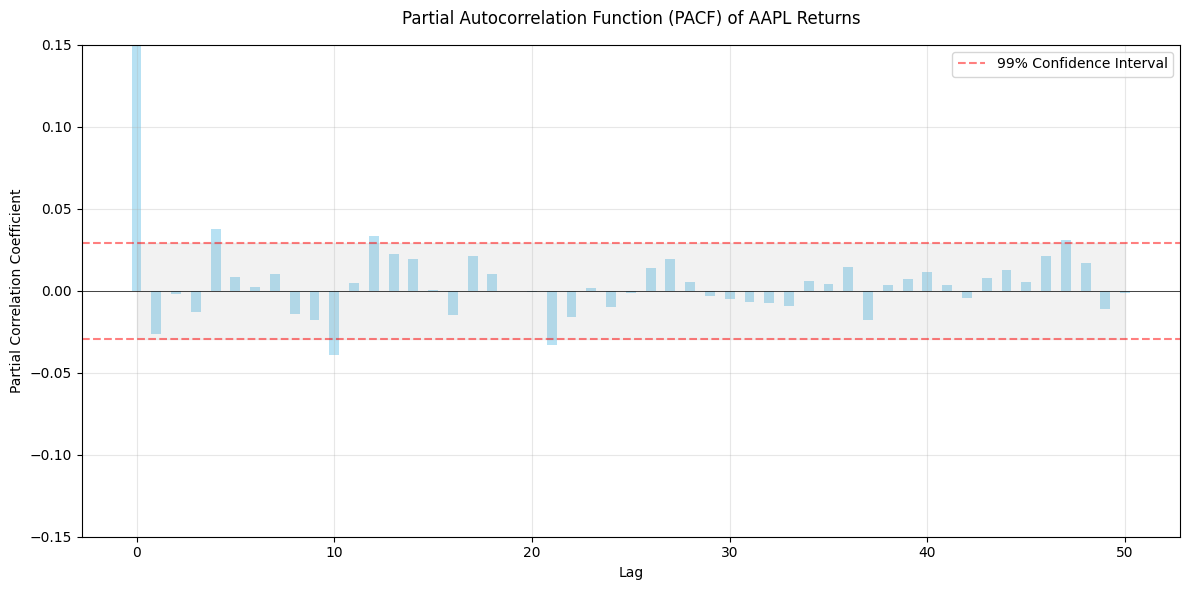


No significant partial autocorrelation found at any lag.
Interpretation: Returns show no direct lag dependencies after accounting for intermediate lags.


In [12]:
# PACF Chart

plt.figure(figsize=(12, 6))

# Calculate PACF values (including lag 0)
pacf_values = pacf(stock_returns, nlags=50, method='ywm')
lags = np.arange(0, len(pacf_values))

# Calculate confidence intervals (either 95% or 99%)
n = len(stock_returns)
#conf_level = 1.96 / np.sqrt(n)      # 95% confidence interval
conf_level = 2.576 / np.sqrt(n)     # 99% confidence interval

# Create the plot
plt.bar(lags, pacf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, 
           label='99% Confidence Interval')
plt.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
plt.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)

plt.title(f'Partial Autocorrelation Function (PACF) of {my_stock.ticker} Returns', pad=15)
plt.xlabel('Lag')
plt.ylabel('Partial Correlation Coefficient')

# Set y-axis limits
max_pacf = max(0.15, max(abs(pacf_values[1:])) * 1.2)
plt.ylim(-max_pacf, max_pacf)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


###########################################################################
# PARTIAL AUTOCORRELATION ANALYSIS AND INTERPRETATION
###########################################################################


# Find significant partial autocorrelation lags (excluding lag 0)
significant_pacf_lags = []
for lag in range(1, len(pacf_values)):
    pacf_val = pacf_values[lag]
    is_stat_sig = abs(pacf_val) > conf_level
    
    # Determine economic significance
    abs_pacf = abs(pacf_val)
    if abs_pacf >= ECONOMIC_THRESHOLDS['very_strong']:
        strength_pacf = "Very Strong"
    elif abs_pacf >= ECONOMIC_THRESHOLDS['strong']:
        strength_pacf = "Strong"
    elif abs_pacf >= ECONOMIC_THRESHOLDS['moderate']:
        strength_pacf = "Moderate"
    else:
        strength_pacf = "Not Significant"

    # Only include if BOTH statistically significant AND at least "Moderate"
    if is_stat_sig and abs_pacf >= ECONOMIC_THRESHOLDS['moderate']:
        significant_pacf_lags.append((lag, pacf_val, strength_pacf))

# Print only significant lags
if significant_pacf_lags:
    print(f"\nSignificant PACF Lags (99% confidence level: ±{conf_level:.4f}):")
    print("-" * 65)
    print(f"{'Lag':<8}{'PACF Value':>12}{'Direction':>15}{'Strength':>15}")
    print("-" * 65)

    for lag, value, strength_pacf in significant_pacf_lags:
        direction = "Positive" if value > 0 else "Negative"
        print(f"{lag:<8}{value:>12.4f}{direction:>15}{strength_pacf:>15}")

    # Calculate percentage of significant lags
    total_lags = len(pacf_values) - 1  # Exclude lag 0
    significant_pacf_percentage = (len(significant_pacf_lags) / total_lags) * 100
    print(f"\nFound {len(significant_pacf_lags)} significant PACF lags out of {total_lags} tested ({significant_pacf_percentage:.1f}%).")
else:
    print("\nNo significant partial autocorrelation found at any lag.")
    print("Interpretation: Returns show no direct lag dependencies after accounting for intermediate lags.")

## Volatility Clustering and Persistence

One of the most prominent features of financial returns is volatility clustering, where large changes tend to be followed by large changes and small changes by small changes.

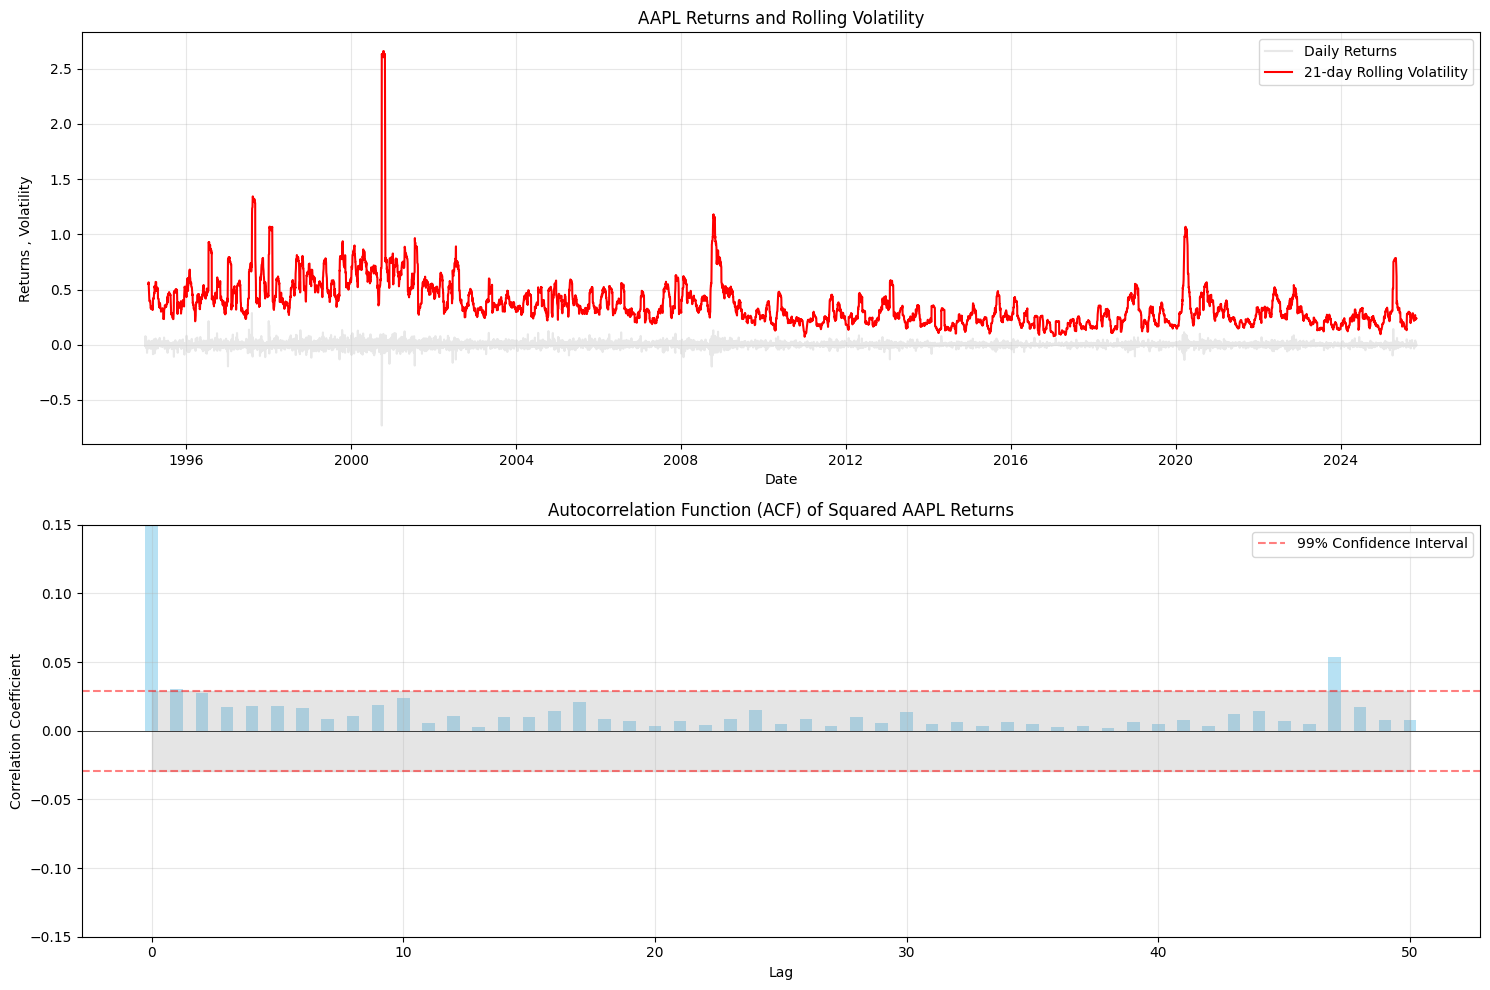


Volatility Clustering Analysis:
---------------------------------------------------------------------------
Total significant lags: 3 out of 150 tested (2.0%)
Longest significant lag: 148 days

Persistence by Time Horizon:
---------------------------------------------------------------------------
Horizon             Significant Lags         Percentage     
---------------------------------------------------------------------------
10 lags (~2 weeks)  1/10                     10.0%          
25 lags (~1 month)  1/25                     4.0%           
75 lags (~3 months) 2/75                     2.7%           

Interpretation:
---------------------------------------------------------------------------
Minimal volatility clustering present.
Volatility shocks are short-term persistent (2-4 weeks).

Decay Analysis:
---------------------------------------------------------------------------
Decay rate from short to long term: 73.3%
Autocorrelation decays rapidly.


In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Returns and Rolling Volatility
window = 21  # approximately one trading month
rolling_vol = stock_returns.rolling(window=window).std() * np.sqrt(252)  # annualized

ax1.plot(stock_returns.index, stock_returns, color='lightgray', alpha=0.5, label='Daily Returns')
ax1.plot(rolling_vol.index, rolling_vol, color='red', linewidth=1.5, label=f'{window}-day Rolling Volatility')
ax1.set_title(f'{my_stock.ticker} Returns and Rolling Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns , Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Custom ACF of Squared Returns
PLOT_LAGS = 50
squared_returns = stock_returns.dropna()**2
acf_values = acf(squared_returns, nlags=PLOT_LAGS, fft=True)
lags = np.arange(0, len(acf_values))

# Calculate confidence intervals
n = len(squared_returns)
#conf_level = 1.96 / np.sqrt(n)      # 95% confidence interval
conf_level = 2.576 / np.sqrt(n)     # 99% confidence interval

# Create the bar plot
ax2.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, label='99% Confidence Interval')
ax2.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
ax2.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.2)

# Set titles and labels
ax2.set_title(f'Autocorrelation Function (ACF) of Squared {my_stock.ticker} Returns')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation Coefficient')

# Set y-axis limits
max_acf = max(0.15, max(abs(acf_values[1:])) * 1.2)
ax2.set_ylim(-max_acf, max_acf)

ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

###########################################################################
# VOLATILITY CLUSTERING ANALYSIS AND INTERPRETATION
###########################################################################

# Re-calculate ACF for more lags (150 lags are approximately 6 months)
MAX_LAGS = 150
acf_sq_values = acf(squared_returns, nlags=MAX_LAGS, fft=True)

# Find significant autocorrelation lags for squared returns
significant_sq_lags = [(lag, acf_sq_values[lag]) for lag in range(1, len(acf_sq_values)) if abs(acf_sq_values[lag]) > conf_level]

# Explore multiple horizons for comprehensive view
# Short-term: first 10 lags (~2 trading weeks)
# Medium-term: first 25 lags (~1 trading month) 
# Long-term: first 75 lags (~3 trading months)
horizons = {
    'short_term': (10, '10 lags (~2 weeks)'),
    'medium_term': (25, '25 lags (~1 month)'),
    'long_term': (75, '75 lags (~3 months)')
}

# Calculate significance for each horizon
horizon_results = {}
for horizon_name, (lag_count, description) in horizons.items():
    significant_in_horizon = sum(1 for lag, _ in significant_sq_lags if lag <= lag_count)
    percentage = (significant_in_horizon / lag_count) * 100
    horizon_results[horizon_name] = (significant_in_horizon, lag_count, percentage, description)

# Find longest significant lag
total_sq_lags = len(acf_sq_values) - 1  # Exclude lag 0
longest_significant_lag = max([lag for lag, _ in significant_sq_lags], default=0)
significant_sq_percentage = (len(significant_sq_lags) / total_sq_lags) * 100


# Print comprehensive summary
print(f"\nVolatility Clustering Analysis:")
print("-" * 75)
print(f"Total significant lags: {len(significant_sq_lags)} out of {total_sq_lags} tested ({significant_sq_percentage:.1f}%)")
print(f"Longest significant lag: {longest_significant_lag} days")
print("\nPersistence by Time Horizon:")
print("-" * 75)
print(f"{'Horizon':<20}{'Significant Lags':<25}{'Percentage':<15}")
print("-" * 75)

for horizon_name, (sig_count, total, pct, desc) in horizon_results.items():
    print(f"{desc:<20}{f'{sig_count}/{total}':<25}{f'{pct:.1f}%':<15}")

# INTERPRETATION: Focus on pattern across horizons
short_pct = horizon_results['short_term'][2]
medium_pct = horizon_results['medium_term'][2]
long_pct = horizon_results['long_term'][2]

print("\nInterpretation:")
print("-" * 75)

# Assess clustering strength based on short-term behavior
if short_pct >= 80:
    strength_clustering = "Very strong"
elif short_pct >= 60:
    strength_clustering = "Strong"
elif short_pct >= 40:
    strength_clustering = "Moderate"
elif short_pct >= 20:
    strength_clustering = "Weak"
else:
    strength_clustering = "Minimal"

print(f"{strength_clustering} volatility clustering present.")

# Assess persistence based on decay pattern
if longest_significant_lag > 50 and long_pct > 60:
    persistence = "highly persistent (extends beyond 2 months)"
elif longest_significant_lag > 25 and medium_pct > 50:
    persistence = "moderately persistent (extends beyond 1 month)"
elif longest_significant_lag > 10:
    persistence = "short-term persistent (2-4 weeks)"
else:
    persistence = "very short-lived (less than 2 weeks)"

print(f"Volatility shocks are {persistence}.")

# Assess decay pattern
decay_rate = (short_pct - long_pct) / short_pct if short_pct > 0 else 0
print(f"\nDecay Analysis:")
print("-" * 75)
print(f"Decay rate from short to long term: {decay_rate:.1%}")

if decay_rate < 0.2:
    decay_desc = "very slowly (typical of financial markets)"
elif decay_rate < 0.4:
    decay_desc = "gradually"
elif decay_rate < 0.6:
    decay_desc = "moderately fast"
else:
    decay_desc = "rapidly"

print(f"Autocorrelation decays {decay_desc}.")

## Leverage Effect Analysis

The leverage effect describes the empirical observation that volatility tends to increase more following negative returns than positive returns of the same magnitude.

We examine this phenomenon across multiple time horizons using two complementary approaches:
1. **Linear regression**: Fits separate lines to positive/negative returns to quantify slope asymmetry
2. **Non-parametric LOWESS**: Reveals the underlying relationship without assuming linearity


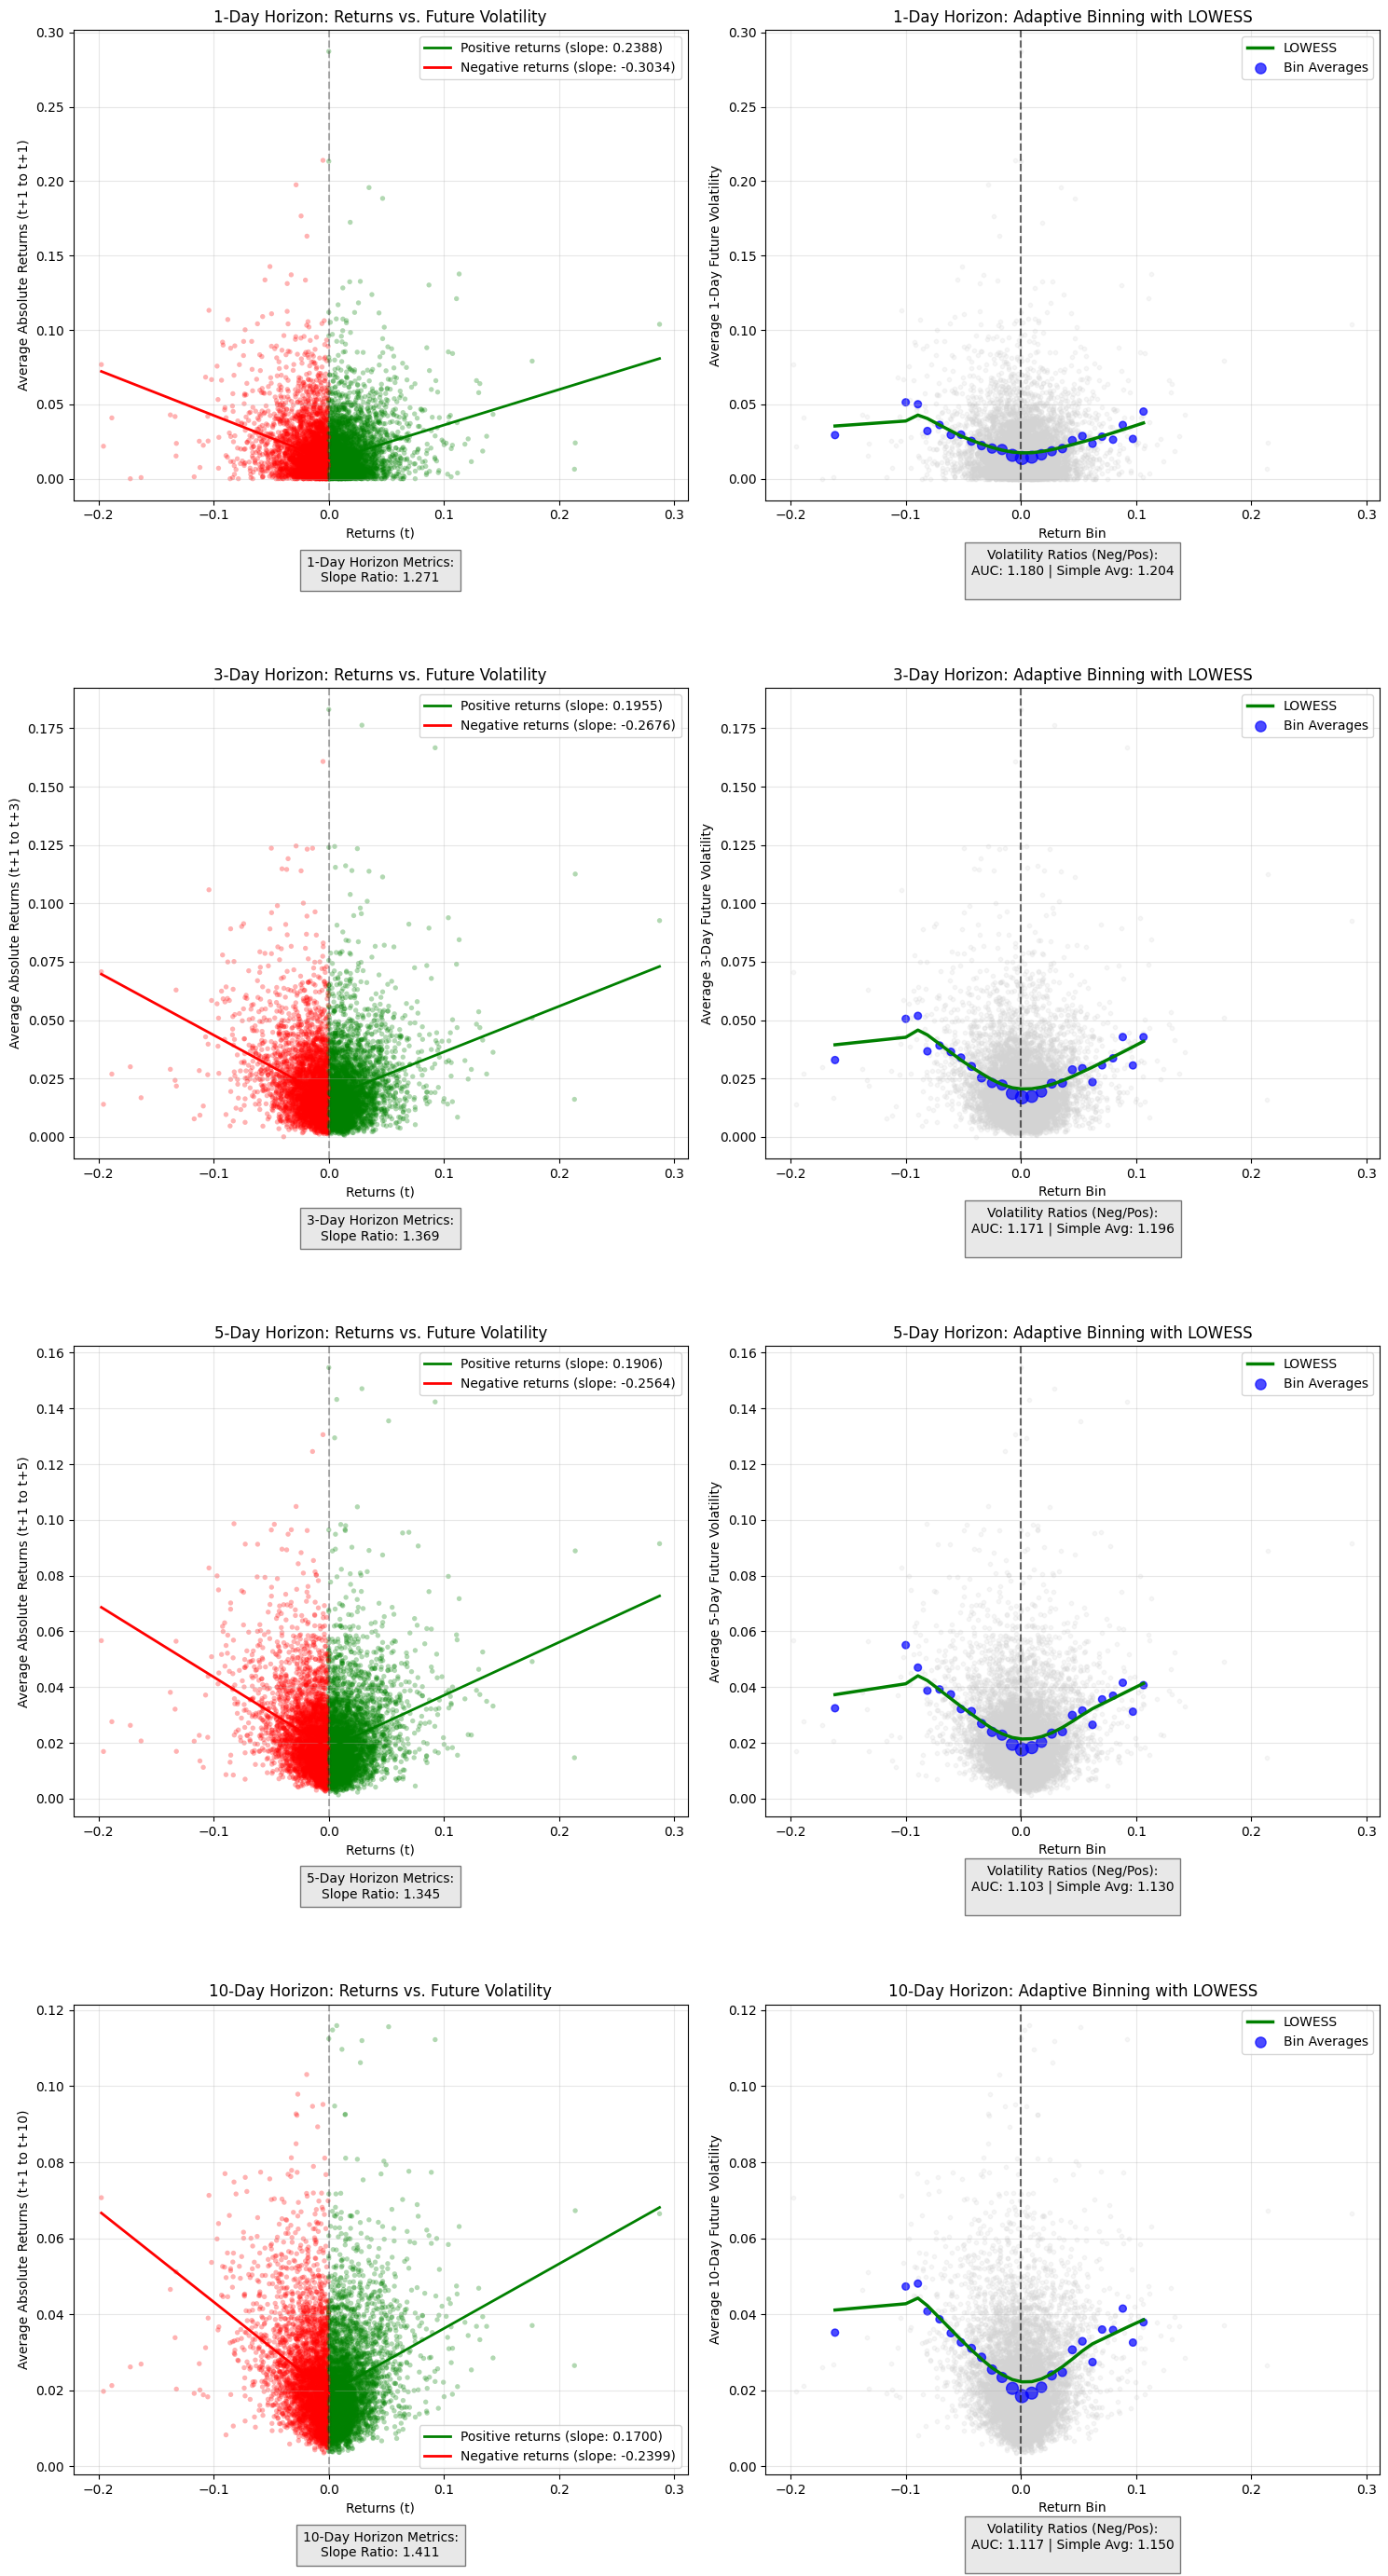


The charts above show the relationship between current returns (x-axis) and subsequent volatility (y-axis) over various horizons.
The left plot uses linear regression to approximate this relationship for positive and negative returns separately.
The right plot employs a more robust, non-parametric approach using adaptive binning and LOWESS smoothing to reveal the underlying trend.

For a leverage effect to be present, we expect an asymmetric behavior: the curve (or line) corresponding to negative returns tends to be steeper or higher than the curve for positive returns.
This can indicate that negative shocks might lead to a significantly larger increase in future volatility.
A symmetrical 'V' shape, for instance, would suggest that empirically we don't see difference in the average behavior.
It's important to remember that this analysis focuses on the magnitude of future returns (volatility), not their direction.


Horizon    Slope Ratio   Vol Ratio       Strength    Significant
-----

In [14]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Prepare data for different horizons (days ahead)
horizons = [1, 3, 5, 10]
fig, axes = plt.subplots(len(horizons), 2, figsize=(15, 7*len(horizons)))

# Create variables to store leverage effect results (to be used later)
multi_day_slope_ratios = {}
multi_day_vol_ratios = {}
multi_day_has_leverage = {}

OUTLIER_K = 15  # IQR multiplier for outlier removal

leverage_returns = remove_outliers(stock_returns, k=OUTLIER_K)

for idx, horizon in enumerate(horizons):
    # Prepare data for current horizon
    current_returns = leverage_returns[:-horizon]
    future_volatility = np.zeros(len(leverage_returns)-horizon)

    # Calculate future volatility as sum of ABSOLUTE RETURNS over the horizon
    #for h in range(horizon):
    #    future_volatility += np.abs(stock_returns[h+1:h+1+len(future_volatility)].values)
    # Calculate future volatility as sum of SQUARED RETURNS over the horizon
    for h in range(horizon):
        future_volatility += np.square(leverage_returns[h+1:h+1+len(future_volatility)].values)
    # Convert sum of squared returns to volatility (standard deviation) by taking square root
    # and normalizing by horizon length to get average daily volatility over the period
    future_volatility = np.sqrt(future_volatility / horizon)

    # Get the current row's axes
    ax1, ax2 = axes[idx]
    
    ### 1. SCATTER PLOT WITH REGRESSION LINES (left plot)

    colors = ['green' if r >= 0 else 'red' for r in current_returns]
    ax1.scatter(current_returns, future_volatility, c=colors, alpha=0.3, edgecolor='none', s=15)
    
    # Add trend lines separately for positive and negative returns
    positive_returns = current_returns[current_returns >= 0]
    negative_returns = current_returns[current_returns < 0]
    positive_volatility = future_volatility[current_returns >= 0]
    negative_volatility = future_volatility[current_returns < 0]

    # Fit trend lines with COMMON INTERCEPT to isolate slope differences
    # This ensures the asymmetry measurement reflects true sensitivity differences,
    # not baseline volatility differences between positive and negative periods
    common_intercept = np.median(future_volatility)

    # Fit slopes with this fixed intercept
    # Formula: slope = Σ((y - intercept) * x) / Σ(x²)
    pos_slope = np.sum((positive_volatility - common_intercept) * positive_returns) / np.sum(positive_returns**2)
    neg_slope = np.sum((negative_volatility - common_intercept) * negative_returns) / np.sum(negative_returns**2)
    
    # Plot trend lines
    x_pos = np.linspace(0, positive_returns.max(), 100)
    ax1.plot(x_pos, pos_slope * x_pos + common_intercept, 'g-', linewidth=2, 
           label=f'Positive returns (slope: {pos_slope:.4f})')
    
    x_neg = np.linspace(negative_returns.min(), 0, 100)
    ax1.plot(x_neg, neg_slope * x_neg + common_intercept, 'r-', linewidth=2, 
           label=f'Negative returns (slope: {neg_slope:.4f})')
    
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax1.set_title(f"{horizon}-Day Horizon: Returns vs. Future Volatility", fontsize=12)
    ax1.set_xlabel("Returns (t)")
    ax1.set_ylabel(f"Average Absolute Returns (t+1 to t+{horizon})")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. ADAPTIVE BINNING APPROACH (right plot)
    ax2.scatter(current_returns, future_volatility, c='lightgray', alpha=0.2, s=10)
    
    # Create adaptive bin edges to group returns for clearer analysis.
    # This is a hybrid approach combining quantile bins (to ensure enough data points in the tails)
    # and linear bins (to maintain resolution around the center).
    # WHY HYBRID APPROACH?
    # - Pure quantile bins: Ensure equal sample sizes in each bin, preventing empty bins in tails
    #   BUT can create overcrowded bins in the center where data is dense
    # - Pure linear bins: Maintain constant spacing for clear visual interpretation
    #   BUT can create empty bins in tails where data is sparse
    NUM_BINS = 35
    BIN_ALPHA = 0.4    # weight for quantile vs linear edges
    linear_edges = np.linspace(current_returns.min(), current_returns.max(), NUM_BINS+1)
    quantile_edges = np.quantile(current_returns, np.linspace(0, 1, NUM_BINS+1))
    bin_edges = BIN_ALPHA * quantile_edges + (1-BIN_ALPHA) * linear_edges

    # Sort bin edges to ensure monotonic ordering
    bin_edges = np.sort(bin_edges)
    
    # Calculate the average return and volatility for each bin.
    # Bins with too few data points (count < 7) are ignored to reduce noise.
    MIN_OBS_PER_BIN = 7
    bin_centers, bin_volatility, bin_counts = [], [], []
    for i in range(NUM_BINS):
        mask = (current_returns >= bin_edges[i]) & (current_returns < bin_edges[i+1])
        count = sum(mask)
        if count >= MIN_OBS_PER_BIN:
            bin_centers.append(np.mean(current_returns[mask]))
            bin_volatility.append(np.mean(future_volatility[mask]))
            bin_counts.append(count)
    
    bin_centers = np.array(bin_centers)
    bin_volatility = np.array(bin_volatility)
    bin_counts = np.array(bin_counts)
    

    # Sort by bin centers (important for LOWESS)
    sort_idx = np.argsort(bin_centers)
    sorted_centers = bin_centers[sort_idx]
    sorted_volatility = bin_volatility[sort_idx]
    sorted_counts = bin_counts[sort_idx]

    # Apply LOWESS to binned data
    # PARAMETER CHOICES:
    # - frac=0.5: Use 50% of data for each local regression
    #   * Higher values (0.7-0.9) → smoother curves but can miss local features
    #   * Lower values (0.2-0.3) → more responsive but can overfit noise
    #   * 0.5 balances smoothness with sensitivity to genuine asymmetries
    LOWESS_FRAC = 0.5
    LOWESS_ITER = 2
    smoothed = lowess(sorted_volatility, sorted_centers, frac=LOWESS_FRAC, it=LOWESS_ITER)
    
    # Plot the LOWESS curve
    ax2.plot(smoothed[:, 0], smoothed[:, 1], 'green', linewidth=2.5, label='LOWESS', zorder=5)
    
    # Plot binned data, with size representing the number of points in each bin.
    sizes = 30 + 70 * sorted_counts / max(sorted_counts)
    ax2.scatter(sorted_centers, sorted_volatility, c='blue', s=sizes, alpha=0.7, label='Bin Averages')

    # Add vertical line at zero for reference
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.4, linewidth=1.5)

    # Split the curve for analysis
    smoothed_neg_mask = smoothed[:, 0] < 0
    smoothed_pos_mask = smoothed[:, 0] > 0

    # Create separate arrays for negative and positive sides
    smoothed_neg = smoothed[smoothed_neg_mask]
    smoothed_pos = smoothed[smoothed_pos_mask]
    
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax2.set_title(f"{horizon}-Day Horizon: Adaptive Binning with LOWESS", fontsize=12)
    ax2.set_xlabel("Return Bin")
    ax2.set_ylabel(f"Average {horizon}-Day Future Volatility")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    
    
    # Calculate and display leverage effect metrics
    # LINEAR Metric: slope ratio from regression lines
    slope_ratio = abs(neg_slope / pos_slope)
    neg_mask = bin_centers < 0
    pos_mask = bin_centers > 0

    if len(smoothed_neg) > 0 and len(smoothed_pos) > 0:
        # NON PARAMETRIC Metric: volatility ratio from LOWESS curves
    
        # Define economically symmetric comparison range
        # Use the common range that both sides cover
        max_neg_return = smoothed_neg[-1, 0]  # Closest point to zero
        min_neg_return = smoothed_neg[0, 0]   # Furthest point from zero
        max_pos_return = smoothed_pos[-1, 0]  # Furthest point from zero
        min_pos_return = smoothed_pos[0, 0]   # Closest point to zero

        # Common range: use the smaller of the two ranges
        # Example: if neg goes to -15% but pos only goes to +12%, use ±12%
        common_range = min(abs(min_neg_return), max_pos_return)

        # SIMPLE APPROACH: Use a single symmetric range
        # Exclude the extreme tails (>95% of range) where data is sparse and LOWESS may be unreliable
        outer_threshold = 0.95 * common_range

        # Define symmetric ranges for comparison
        neg_lower = -outer_threshold
        neg_upper = 0
        pos_lower = 0
        pos_upper = outer_threshold

        # Extract LOWESS points within these symmetric ranges
        neg_mask = (smoothed_neg[:, 0] >= neg_lower) & (smoothed_neg[:, 0] <= neg_upper)
        pos_mask = (smoothed_pos[:, 0] >= pos_lower) & (smoothed_pos[:, 0] <= pos_upper)

        neg_range_points = smoothed_neg[neg_mask]
        pos_range_points = smoothed_pos[pos_mask]

        if len(neg_range_points) > 1 and len(pos_range_points) > 1:

            # METHOD 1: AUC (Area Under Curve) approach
            # Calculate area using trapezoidal integration
            auc_neg = np.trapz(neg_range_points[:, 1], neg_range_points[:, 0])
            auc_pos = np.trapz(pos_range_points[:, 1], pos_range_points[:, 0])

            # Normalize by x-axis range to get "average height" (average volatility)
            x_range_neg = neg_upper - neg_lower
            x_range_pos = pos_upper - pos_lower
            
            avg_vol_neg_auc = abs(auc_neg) / x_range_neg
            avg_vol_pos_auc = auc_pos / x_range_pos
            
            vol_ratio_auc = avg_vol_neg_auc / avg_vol_pos_auc if avg_vol_pos_auc > 0 else 1.0

            # METHOD 2: Simple average of y-values (for comparison)
            avg_vol_neg_simple = np.mean(neg_range_points[:, 1])
            avg_vol_pos_simple = np.mean(pos_range_points[:, 1])

            vol_ratio_simple = avg_vol_neg_simple / avg_vol_pos_simple if avg_vol_pos_simple > 0 else 1.0

            # Choose which volume ratio to use: vol_ratio_auc or vol_ratio_simple
            vol_ratio = vol_ratio_auc
        
        
            # Store results
            multi_day_slope_ratios[horizon] = slope_ratio
            multi_day_vol_ratios[horizon] = vol_ratio
        
            # Add metrics as text box for linear regression plot (ax1)
            axes[idx, 0].text(
                0.5, -0.15,
                f"{horizon}-Day Horizon Metrics:\n"
                f"Slope Ratio: {slope_ratio:.3f}",
                transform=axes[idx, 0].transAxes,
                ha='center', va='center',
                bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5}
            )
        
            # Add vol_ratio explanation and value under the LOWESS plot (ax2)
            axes[idx, 1].text(
                0.5, -0.15,
                f"Volatility Ratios (Neg/Pos):\n"
                f"AUC: {vol_ratio_auc:.3f} | Simple Avg: {vol_ratio_simple:.3f}\n",
                transform=axes[idx, 1].transAxes,
                ha='center', va='center',
                bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5}
            )
        

# Apply tight layout but with extra bottom margin for the text boxes
plt.tight_layout()
plt.subplots_adjust(bottom=0.05, hspace=0.4)  # Increase spacing between rows
plt.show()

print("\nThe charts above show the relationship between current returns (x-axis) and subsequent volatility (y-axis) over various horizons.")
print("The left plot uses linear regression to approximate this relationship for positive and negative returns separately.")
print("The right plot employs a more robust, non-parametric approach using adaptive binning and LOWESS smoothing to reveal the underlying trend.")
print("\nFor a leverage effect to be present, we expect an asymmetric behavior: the curve (or line) corresponding to negative returns " \
"tends to be steeper or higher than the curve for positive returns.")
print("This can indicate that negative shocks might lead to a significantly larger increase in future volatility.")
print("A symmetrical 'V' shape, for instance, would suggest that empirically we don't see difference in the average behavior.")
print("It's important to remember that this analysis focuses on the magnitude of future returns (volatility), not their direction.")
print("\n")

#############################################################################
# LEVERAGE EFFECT SUMMARY AND INTERPRETATION
#############################################################################

# Define consistent thresholds for both metrics
THRESHOLD_VERY_STRONG = 1.25  # 25% higher volatility for negative returns
THRESHOLD_STRONG = 1.15       # 15% higher
THRESHOLD_MODERATE = 1.05     # 5% higher

    
# Analyze each horizon
leverage_horizon_results = []
for horizon in horizons:
    if horizon in multi_day_slope_ratios and horizon in multi_day_vol_ratios:
        slope_ratio = multi_day_slope_ratios[horizon]
        vol_ratio = multi_day_vol_ratios[horizon]
        
        # Determine strength - BOTH metrics must agree
        # (This ensures we're not detecting false positives)
        if slope_ratio > THRESHOLD_VERY_STRONG and vol_ratio > THRESHOLD_VERY_STRONG:
            strength = "Very Strong"
            has_leverage = True
        elif slope_ratio > THRESHOLD_STRONG and vol_ratio > THRESHOLD_STRONG:
            strength = "Strong"
            has_leverage = True
        elif slope_ratio > THRESHOLD_MODERATE and vol_ratio > THRESHOLD_MODERATE:
            strength = "Moderate"
            has_leverage = True
        else:
            strength = "Weak/None"
            has_leverage = False

        leverage_horizon_results.append((horizon, slope_ratio, vol_ratio, strength, has_leverage))

# Print detailed results for each horizon
print(f"{'Horizon':<10}{'Slope Ratio':>12}{'Vol Ratio':>12}{'Strength':>15}{'Significant':>15}")
print("-" * 65)
for horizon, slope_ratio, vol_ratio, strength, is_significant in leverage_horizon_results:
    significance = "Yes" if is_significant else "No"
    print(f"{horizon}-day{'':<6}{slope_ratio:>12.3f}{vol_ratio:>12.3f}{strength:>15}{significance:>15}")

# Calculate overall metrics
significant_horizons = sum(1 for _, _, _, _, sig in leverage_horizon_results if sig)
total_horizons = len(leverage_horizon_results)
significant_percentage = (significant_horizons / total_horizons) * 100 if total_horizons > 0 else 0

print(f"\nHorizons with significant leverage effect: {significant_horizons} out of {total_horizons} ({significant_percentage:.1f}%)")

# Determine overall leverage effect strength
if significant_horizons == 0:
    overall_strength = "No"
    interpretation = "No evidence of leverage effect found across any time horizon."
elif significant_percentage < 50:
    overall_strength = "Weak"
    interpretation = "Limited evidence of leverage effect, present only at specific horizons."
elif all(strength in ["Strong", "Very Strong"] for _, _, _, strength, sig in leverage_horizon_results if sig):
    overall_strength = "Strong"
    interpretation = "Strong leverage effect consistently observed across multiple time horizons."
else:
    overall_strength = "Moderate"
    interpretation = "Moderate leverage effect observed, with varying strength across different horizons."

# Find strongest horizon if applicable
if significant_horizons > 0:
    # Find horizon with highest combined strength (average of both ratios)
    strongest = max(((sr + vr) / 2, h, sr, vr) for h, sr, vr, _, sig in leverage_horizon_results if sig)
    strongest_horizon = strongest[1]
    strongest_slope = strongest[2]
    strongest_vol = strongest[3]
    
    print(f"Strongest effect observed at {strongest_horizon}-day horizon")
    print(f"  Slope Ratio: {strongest_slope:.3f}, Vol Ratio: {strongest_vol:.3f}")

# Print overall assessment with concise interpretation
print(f"\nInterpretation: {interpretation}")

## Summary of Key Findings

Let's summarize the main statistical characteristics of our financial time series:

In [ ]:
from IPython.display import Markdown

summary = f"""
### Key Statistical Properties of {my_stock.ticker}

1. **Distribution Characteristics**
    - Mean return is {stock_returns.mean():.6f}, close to zero but slightly {("positive" if stock_returns.mean() > 0 else "negative")}
    - {"Heavy tails with" if stock_returns.kurtosis() > 3 else "Near-normal"} excess kurtosis of {stock_returns.kurtosis():.4f} {"(much higher than a normal distribution)" if stock_returns.kurtosis() > 3 else ""}
    - {"Strongly non-normal" if p_value < 0.001 else "Moderately non-normal" if p_value < 0.05 else "Approximately normal"} distribution based on Jarque-Bera test (p-value = {p_value:.6f})
    - {"Significant" if abs(stock_returns.skew()) > 0.5 else "Slight"} skewness of {stock_returns.skew():.4f}, indicating {("positive" if stock_returns.skew() > 0 else "negative")} asymmetry

2. **Time Series Properties**
   - Returns are {"stationary" if adf_result[1] < 0.05 else "potentially non-stationary"} based on ADF test (p-value: {adf_result[1]:.6f})
   - {("Significant" if len(significant_lags) > 10 else "Some" if len(significant_lags) > 0 else "No")} autocorrelation in returns {(f"with {len(significant_lags)} significant lags" if len(significant_lags) > 0 else "(consistent with market efficiency)")}
   - {("Significant" if len(significant_pacf_lags) > 5 else "Some" if len(significant_pacf_lags) > 0 else "No")} direct lag dependencies in PACF {(f"with {len(significant_pacf_lags)} significant lags" if len(significant_pacf_lags) > 0 else "")}

3. **Volatility Dynamics**
   - {strength_clustering} volatility clustering observed ({horizon_results['short_term'][2]:.1f}% significant lags in first {horizon_results['short_term'][1]} days)
   - Volatility persistence is {persistence} (longest significant lag at {longest_significant_lag} days)
   - Decay pattern: {horizon_results['short_term'][2]:.1f}% → {horizon_results['medium_term'][2]:.1f}% → {horizon_results['long_term'][2]:.1f}% (short → medium → long term)
   - Overall decay rate: {decay_rate:.1%}

4. **Leverage Effect**
   - {overall_strength} leverage effect detected across {significant_horizons} out of {total_horizons} time horizons ({significant_percentage:.1f}%)
   - {f"Strongest leverage effect observed at {strongest_horizon}-day horizon" if significant_horizons > 0 else "No significant leverage effect observed"}

The analysis provides a solid foundation for more advanced modeling approaches such as GARCH models or option pricing that account for these empirical characteristics.
"""

display(Markdown(summary))